### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

from training.creating_dataset import load_and_preprocess_data

sys.path.append("../../..")

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
characteristics = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=characteristics,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   perception  1206 non-null   int64 
 1   int         1206 non-null   int64 
 2   will        1206 non-null   int64 
 3   fortitude   1206 non-null   int64 
 4   hp          1206 non-null   int64 
 5   cha         1206 non-null   int64 
 6   book        1206 non-null   object
 7   dex         1206 non-null   int64 
 8   level       1206 non-null   int64 
 9   reflex      1206 non-null   int64 
 10  ac          1206 non-null   int64 
 11  wis         1206 non-null   int64 
 12  con         1206 non-null   int64 
 13  str         1206 non-null   int64 
 14  focus       1206 non-null   int32 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,perception,int,will,fortitude,hp,cha,book,dex,level,reflex,ac,wis,con,str,focus
0,20,1,17,22,215,1,Pathfinder Bestiary,2,10,19,29,2,5,7,1
1,16,-4,16,21,220,1,Pathfinder Bestiary,0,10,14,28,2,5,9,0
2,17,-4,15,20,175,-2,Pathfinder Bestiary,3,8,17,25,3,6,7,0
3,30,6,32,30,315,6,Pathfinder Bestiary,4,17,29,41,5,5,7,1
4,6,-1,4,6,20,1,Pathfinder Bestiary,3,1,10,16,1,1,-5,1


## Train test split

### Chronological split

In [4]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/random_forest")

In [5]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

In [6]:
X_train = X_train.astype("int64")
y_train = y_train.astype("int64")

### Random split

In [7]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [8]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## Random Forest

### With chronological split

In [9]:
from sklearn.ensemble import RandomForestRegressor


rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [10]:
y_pred_train = rf_reg.predict(X_train)
y_pred_test = rf_reg.predict(X_test)

In [11]:
from sklearn.metrics import mean_squared_error


mse = mean_squared_error(y_test, y_pred_test)
rmse = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 2.12
RMSE: 1.45


In [12]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Number of characteristics": [],
        "MSE": [],
        "RMSE": [],
    }
)

results.loc[0] = ["chronological", "normal", len(X_test.columns), mse, rmse]

In [13]:
from training.results import check_round_predictions, plot_confusion_matrix


check_round_predictions(["round", 0.33, 0.45], y_test, y_pred_test)

Normal:
MSE: 2.12
RMSE: 1.45

Round type: round
MSE: 2.38
RMSE: 1.54

Round type: 0.33
MSE: 2.13
RMSE: 1.46

Round type: 0.45
MSE: 2.12
RMSE: 1.46



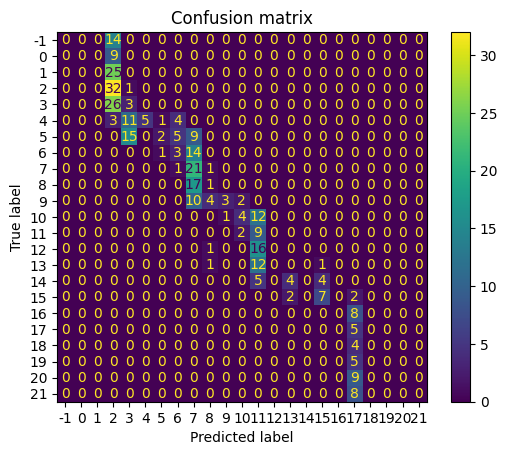

In [14]:
plot_confusion_matrix("round", y_pred_test, y_test)

#### Tuning

In [15]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [16]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   5.3s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.5s
[CV] END ...max_depth=70, max_features=0.2, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.2s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.1s
[CV] END ...max_depth=30, max_features=0.4, n_estimators=700; total time=   1.7s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.7s
[CV] END ...max_depth=90, max_features=0.3, n_estimators=200; total time=   0.7s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   1.5s
[CV] END .max_depth=None, max_features=0.1, n_estimators=800; total time=   1.4s
[CV] END .max_depth=None, max_features=0.1, n_

{'n_estimators': 700, 'max_features': 0.4, 'max_depth': 30}

In [17]:
from training.results import assess_regression_model


rmse, mse = assess_regression_model(rf_random, X_train, X_test, y_train, y_test)

RMSE train: 0.14
RMSE test: 0.50
MSE test: 0.25



In [18]:
results.loc[1] = ["chronological", "RandomizedSearchCV", len(X_test.columns), mse, rmse]

In [19]:
predict = rf_random.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.25
RMSE: 0.50

Round type: round
MSE: 0.28
RMSE: 0.53

Round type: 0.33
MSE: 0.27
RMSE: 0.52

Round type: 0.45
MSE: 0.28
RMSE: 0.53



### Attempt to decrease overfitting
Change max_depth to 8

In [20]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=600, max_features=0.5, max_depth=8
)
rf.fit(X_train, y_train)
rmse, mse = assess_regression_model(rf, X_train, X_test, y_train, y_test)

RMSE train: 0.19
RMSE test: 0.51
MSE test: 0.26



In [21]:
results.loc[2] = [
    "chronological",
    "minimalise_overfitting",
    len(X_test.columns),
    mse,
    rmse,
]

In [22]:
predict = rf.predict(X_test)
check_round_predictions(["round", 0.33, 0.45], y_test, predict)

Normal:
MSE: 0.26
RMSE: 0.51

Round type: round
MSE: 0.31
RMSE: 0.56

Round type: 0.33
MSE: 0.30
RMSE: 0.54

Round type: 0.45
MSE: 0.30
RMSE: 0.55



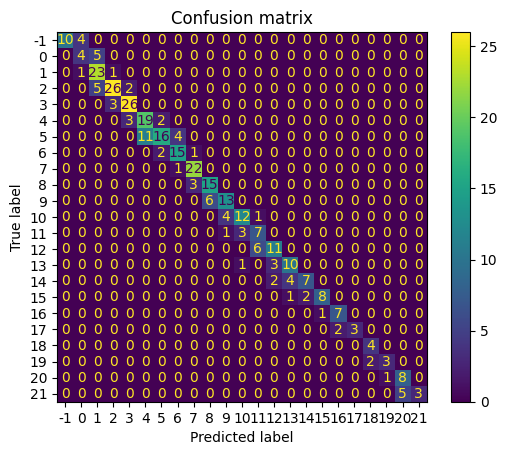

In [23]:
plot_confusion_matrix("round", predict, y_test)

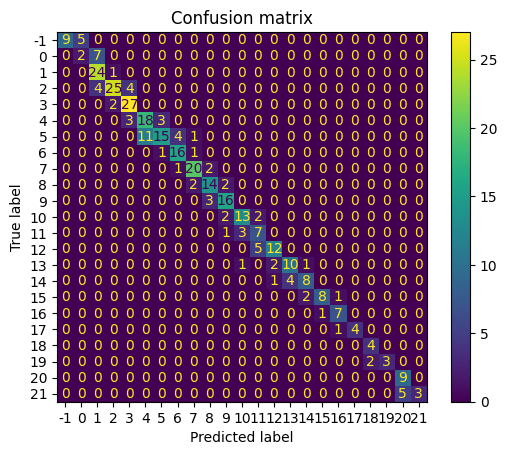

In [24]:
plot_confusion_matrix(0.33, predict, y_test)

### Random split

In [25]:
rf_reg = RandomForestRegressor(n_estimators=500, max_depth=2, random_state=0, n_jobs=-1)
rf_reg.fit(X_train_random_split, y_train_random_split)

RandomForestRegressor(max_depth=2, n_estimators=500, n_jobs=-1, random_state=0)

In [26]:
y_pred_train = rf_reg.predict(X_train_random_split)
y_pred_test = rf_reg.predict(X_test_random_split)

In [27]:
mse = mean_squared_error(y_test_random_split, y_pred_test)
rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MSE: 1.57
RMSE: 1.25


In [28]:
results.loc[3] = ["random", "normal", len(X_test.columns), mse, rmse]

In [29]:
check_round_predictions(["round", 0.33, 0.45], y_test_random_split, y_pred_test)

Normal:
MSE: 1.57
RMSE: 1.25

Round type: round
MSE: 1.66
RMSE: 1.29

Round type: 0.33
MSE: 1.68
RMSE: 1.30

Round type: 0.45
MSE: 1.65
RMSE: 1.29



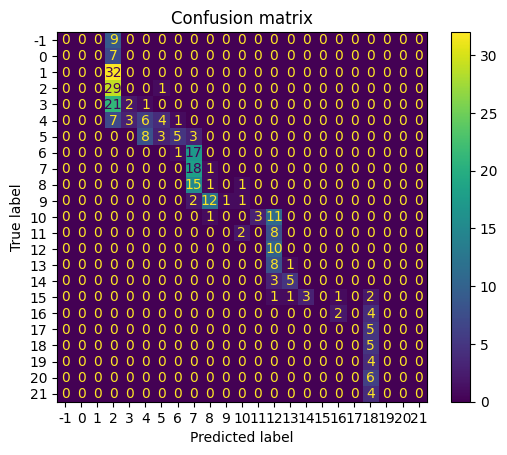

In [30]:
plot_confusion_matrix("round", y_pred_test, y_test_random_split)

#### Tuning

In [31]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=800, num=8)]
max_features = [0.1, 0.2, 0.3, 0.4, 0.5]
max_depth = list(range(10, 111, 10)) + [None]

hyper_params = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
}

hyper_params

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None]}

In [32]:
rf = RandomForestRegressor(random_state=0, n_jobs=-1)

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=hyper_params,
    n_iter=100,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42,
    return_train_score=True,
)

rf_random.fit(X_train_random_split, y_train_random_split)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.4s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.8s
[CV] END ...max_depth=20, max_features=0.5, n_estimators=200; total time=   0.3s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.7s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.5s
[CV] END ..max_depth=110, max_features=0.2, n_estimators=700; total time=   1.6s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.0s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   0.6s
[CV] END ..max_depth=100, max_features=0.5, n_estimators=300; total time=   1.4s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.6s
[CV] END ...max_depth=70, max_features=0.5, n_estimators=600; total time=   1.4s
[CV] END ...max_depth=70, max_features=0.5, n_

{'n_estimators': 700, 'max_features': 0.5, 'max_depth': 90}

In [33]:
rmse, mse = assess_regression_model(
    rf_random,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.15
RMSE test: 0.37
MSE test: 0.13



In [34]:
results.loc[4] = ["random", "RandomizedSearchCV", len(X_test.columns), mse, rmse]

### Attempt to decrease overfitting
Change max_depth to 13

In [35]:
rf = RandomForestRegressor(
    random_state=0, n_jobs=-1, n_estimators=800, max_features=0.5, max_depth=13
)
rf.fit(X_train, y_train)
rmse, mse = assess_regression_model(
    rf,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.30
RMSE test: 0.30
MSE test: 0.09



In [36]:
results.loc[5] = ["random", "minimalise_overfitting", len(X_test.columns), mse, rmse]

Check rounded predictions

In [37]:
predict_random_split = rf.predict(X_test_random_split)

check_round_predictions(
    ["round", 0.33, 0.45], y_test_random_split, predict_random_split
)

Normal:
MSE: 0.09
RMSE: 0.30

Round type: round
MSE: 0.10
RMSE: 0.32

Round type: 0.33
MSE: 0.09
RMSE: 0.30

Round type: 0.45
MSE: 0.10
RMSE: 0.32



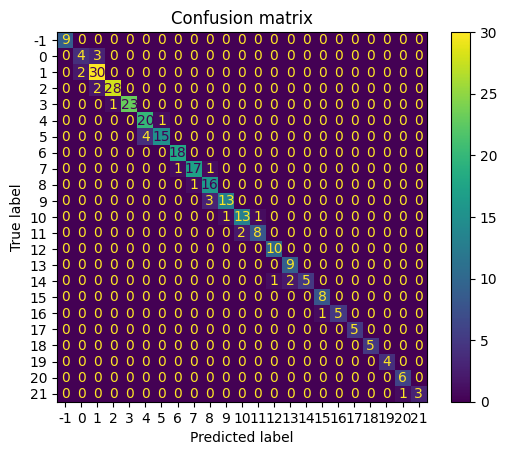

In [38]:
plot_confusion_matrix("round", predict_random_split, y_test_random_split)

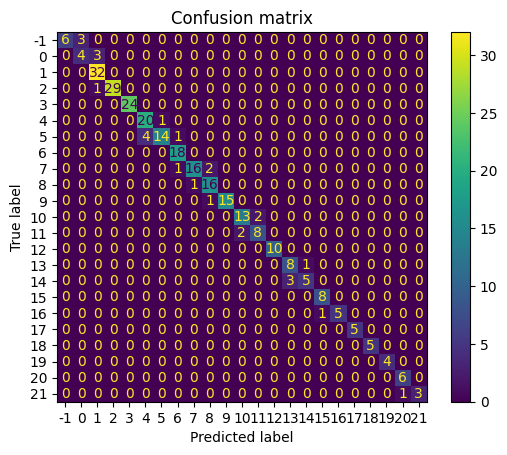

In [39]:
plot_confusion_matrix(0.33, predict_random_split, y_test_random_split)

## Summary

In [40]:
results

,Split type,Tuning type,Number of characteristics,MSE,RMSE
0,chronological,normal,13,2.115397,1.454440
1,chronological,RandomizedSearchCV,13,0.245475,0.495454
2,chronological,minimalise_overfitting,13,0.259789,0.509695
3,random,normal,13,1.568874,1.252547
4,random,RandomizedSearchCV,13,0.133846,0.365850
5,random,minimalise_overfitting,13,0.091108,0.301842


In [41]:
from training.results import plot_summary

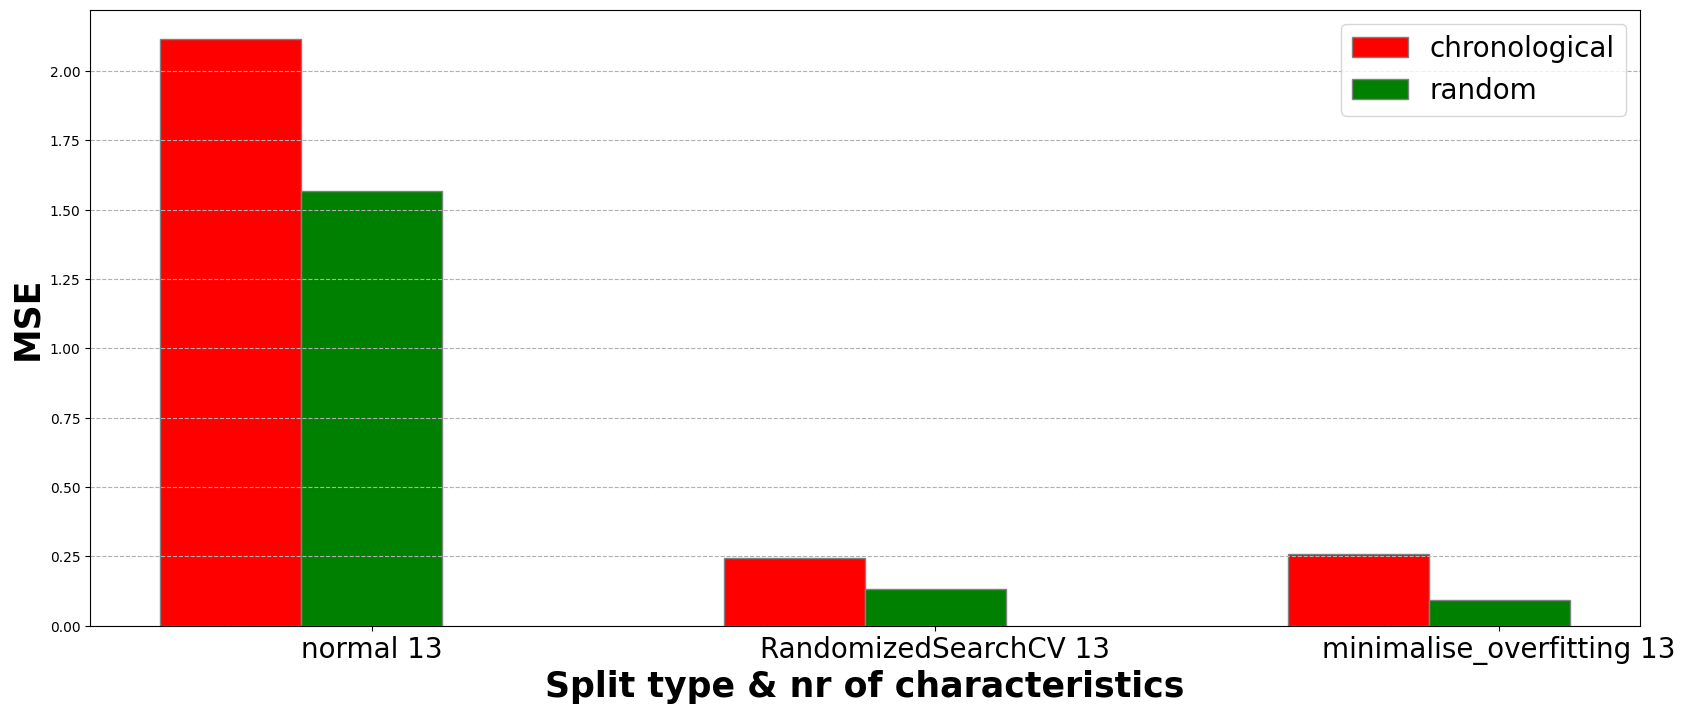

In [42]:
plot_summary(results, "MSE")

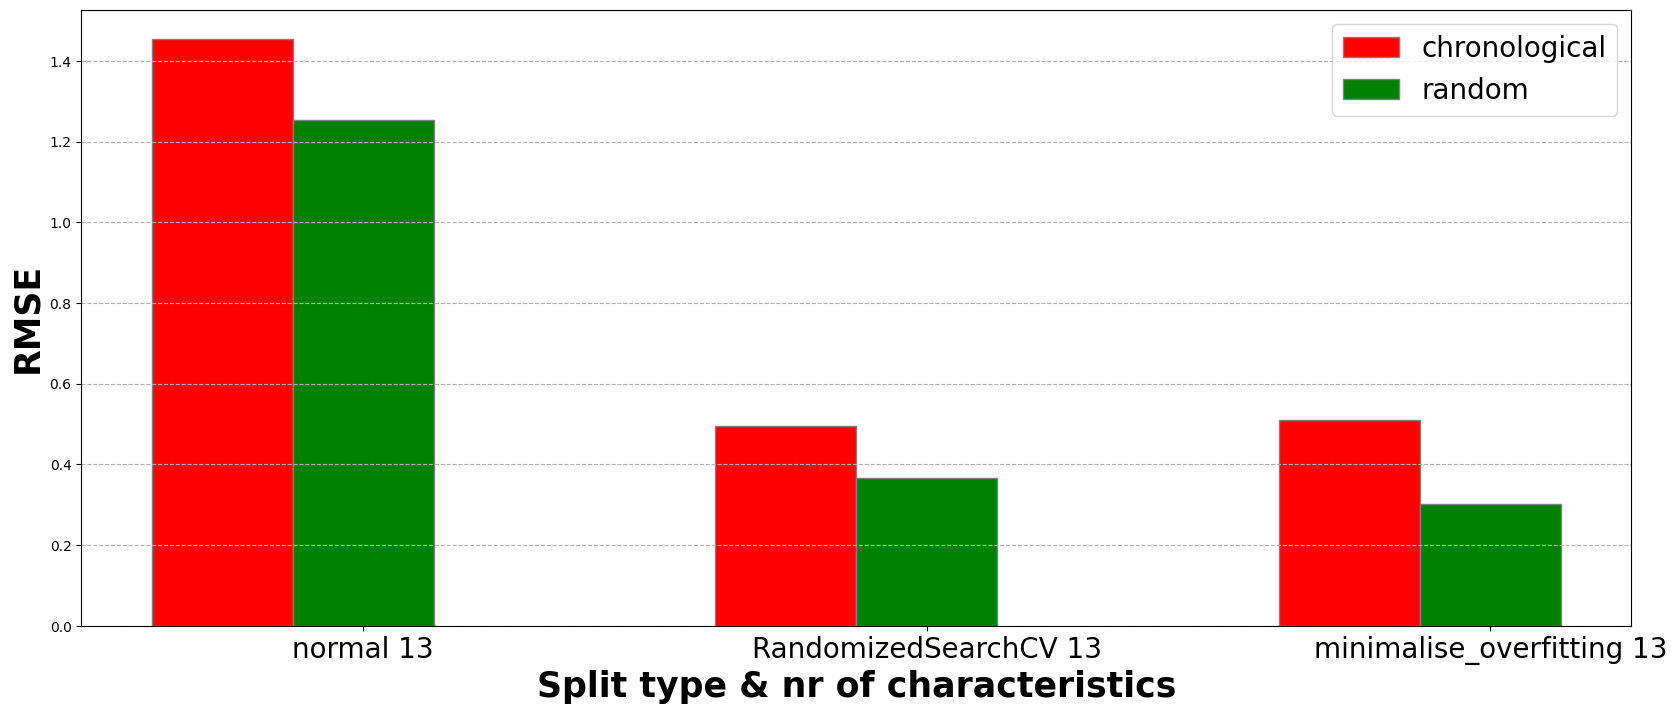

In [43]:
plot_summary(results, "RMSE")

In [44]:
results.to_json("./random_forest_second_results.json")